In [1]:
from ROOT import RDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm

from fftprep.fftprep import make_img, fft_filter, fft_filter_pairwise, reconstruct_img, complete_data_pw, load_from_sparse

from scipy.signal import detrend

import pickle

from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from scipy.optimize import curve_fit

In [2]:
data = RDataFrame("t;1", "FastSim_E5GeV.root").AsNumpy()
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data
subset = (X.transpose()[1]>500) \
            *(X.transpose()[1]<3500) \
            *(X.transpose()[2]>500) \
            *(X.transpose()[2]<2500) \
            *(X.transpose()[3]>12280) \
            *(X.transpose()[3]<12300) \
            *(X.transpose()[4]<0.6) \
            *(X.transpose()[5]<2*np.pi) \
    
X_fast, obs_fast = X[subset], obs[subset]
del X
del obs

In [3]:
data = RDataFrame("t;1", "FullSim_E5GeV.root").AsNumpy()
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data
subset = (X.transpose()[1]>500) \
            *(X.transpose()[1]<3500) \
            *(X.transpose()[2]>500) \
            *(X.transpose()[2]<2500) \
            *(X.transpose()[3]>12280) \
            *(X.transpose()[3]<12300) \
            *(X.transpose()[4]<0.6) \
            *(X.transpose()[5]<2*np.pi) \
    
X_full, obs_full = X[subset], obs[subset]
del X
del obs

In [119]:
fft_filt_data_pw = load_from_sparse(return_full=True, n_sigma = 3)

params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (0,0.05),
        "reso": 100
    }, 
    "phi": {
        "range": (0,2*np.pi),
        "reso": 10
    }
}

model = fftpredictor(fft_filt_data_pw, params)

TypeError: load_from_sparse() got an unexpected keyword argument 'n_sigma'

In [7]:
preds = []
for row in tqdm(X_full):
    preds.append(model.predict((row[1], row[2], row[4], row[5])))

100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [12:31<00:00, 67925.50it/s]


In [43]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.05),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
fft_cor_data_binned = make_img(X_sel, np.array(preds), params)

[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 448.34it/s]


[2/2] creating image...


In [101]:
fast_sim_data_binned_corrected = detrend(fft_cor_data_binned, bp = (0,150,300)) + fast_sim_data_binned

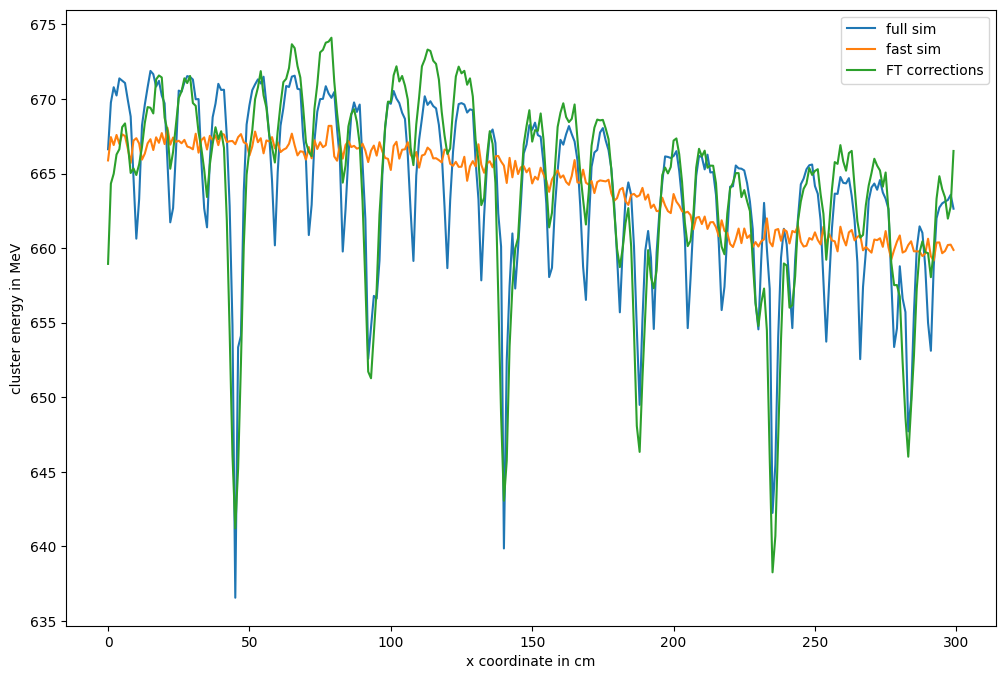

In [104]:
plt.figure(figsize=(12,8))
plt.plot(full_sim_data_binned)
#plt.plot(fft_cor_data_binned - 3*660)
plt.plot(fast_sim_data_binned)
plt.plot(fast_sim_data_binned_corrected)
plt.xlabel("x coordinate in cm")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim", "fast sim", "FT corrections"])

Text(0, 0.5, 'Error')

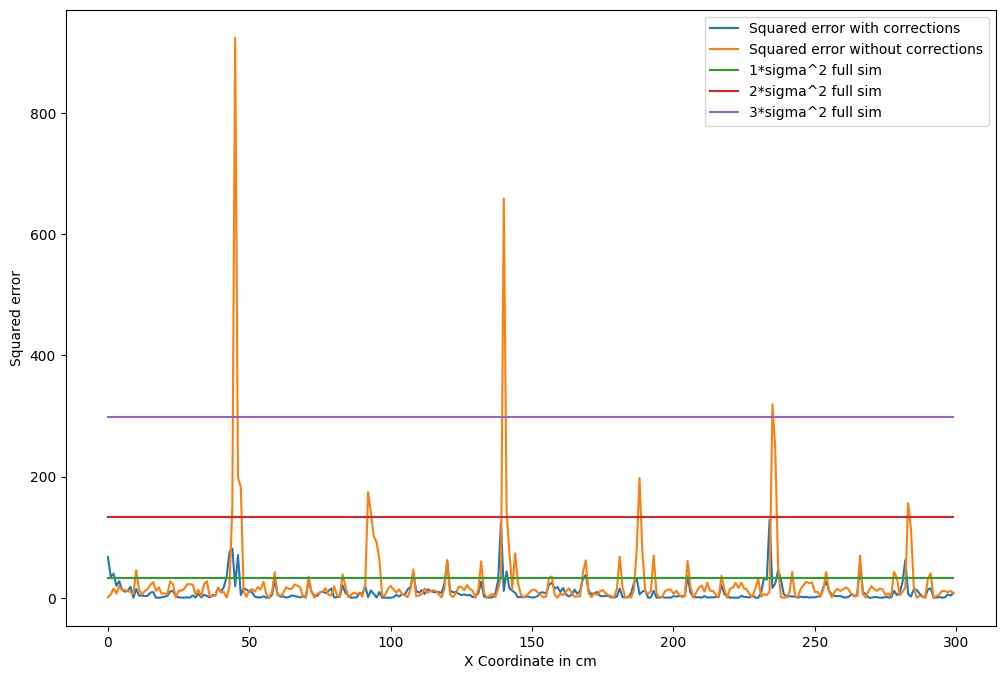

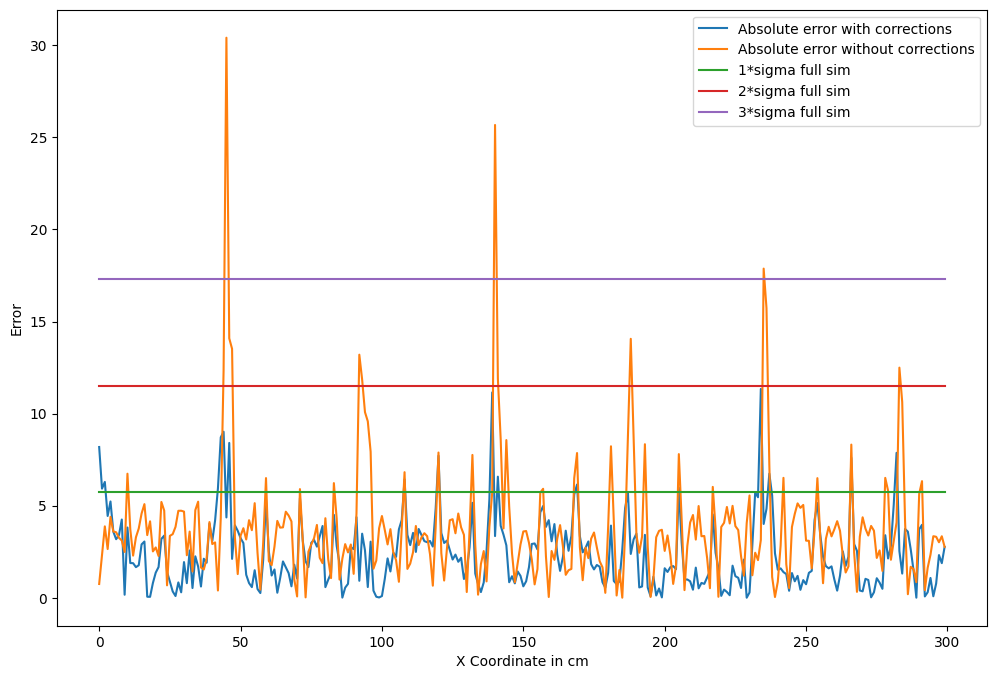

In [95]:
plt.figure(figsize=(12,8))
plt.plot((fast_sim_data_binned_corrected - full_sim_data_binned)**2)
plt.plot((fast_sim_data_binned - full_sim_data_binned)**2)
plt.plot(np.array(300*[1*np.std(full_sim_data_binned)])**2)
plt.plot(np.array(300*[2*np.std(full_sim_data_binned)])**2)
plt.plot(np.array(300*[3*np.std(full_sim_data_binned)])**2)
plt.legend(["Squared error with corrections", "Squared error without corrections", "1*sigma^2 full sim", "2*sigma^2 full sim", "3*sigma^2 full sim"])
plt.xlabel("X Coordinate in cm")
plt.ylabel("Squared error")
plt.figure(figsize=(12,8))
plt.plot(abs(fast_sim_data_binned_corrected - full_sim_data_binned))
plt.plot(abs(fast_sim_data_binned - full_sim_data_binned))
plt.plot(np.array(300*[1*np.std(full_sim_data_binned)]))
plt.plot(np.array(300*[2*np.std(full_sim_data_binned)]))
plt.plot(np.array(300*[3*np.std(full_sim_data_binned)]))
plt.legend(["Absolute error with corrections", "Absolute error without corrections", "1*sigma full sim", "2*sigma full sim", "3*sigma full sim"])
plt.xlabel("X Coordinate in cm")
plt.ylabel("Error")

In [24]:
def make_1d_comparison(params):
    fft_cor_data_binned = make_img(X_full, np.array(preds), params)
    fast_sim_data_binned = make_img(X_fast, obs_fast, params)
    full_sim_data_binned = make_img(X_full, obs_full, params)
    fast_sim_data_binned_corrected = detrend(fft_cor_data_binned*2 - np.mean(fft_cor_data_binned)) + fast_sim_data_binned
    plt.figure(figsize=(12,8))
    plt.plot(full_sim_data_binned)
    plt.plot(fast_sim_data_binned_corrected)
    plt.plot(fft_cor_data_binned*2 - np.mean(fft_cor_data_binned))
    plt.legend(["full sim", "fast sim with corrections", "FT corrections"])
    plt.figure(figsize=(12,8))
    plt.plot((fast_sim_data_binned_corrected - full_sim_data_binned)**2)
    plt.plot((fast_sim_data_binned - full_sim_data_binned)**2)
    plt.plot(np.array(fft_cor_data_binned.shape[0]*[1*np.std(full_sim_data_binned)])**2)
    plt.plot(np.array(fft_cor_data_binned.shape[0]*[2*np.std(full_sim_data_binned)])**2)
    plt.plot(np.array(fft_cor_data_binned.shape[0]*[3*np.std(full_sim_data_binned)])**2)
    plt.legend(["Squared error with corrections", "Squared error without corrections", "1*sigma^2 full sim", "2*sigma^2 full sim", "3*sigma^2 full sim"])
    plt.xlabel("X Coordinate in cm")
    plt.ylabel("Squared error")




In [110]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (0,0.05),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
#make_1d_comparison(params)

In [111]:
fft_cor_data_binned = make_img(X_full, np.array(preds), params)
fast_sim_data_binned = make_img(X_fast, obs_fast, params)
full_sim_data_binned = make_img(X_full, obs_full, params)
fast_sim_data_binned_corrected = detrend(fft_cor_data_binned) + fast_sim_data_binned

[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 382.23it/s]


[2/2] creating image...
[1/2] binning data...


100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1165.89it/s]


[2/2] creating image...
[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 730.71it/s]


[2/2] creating image...


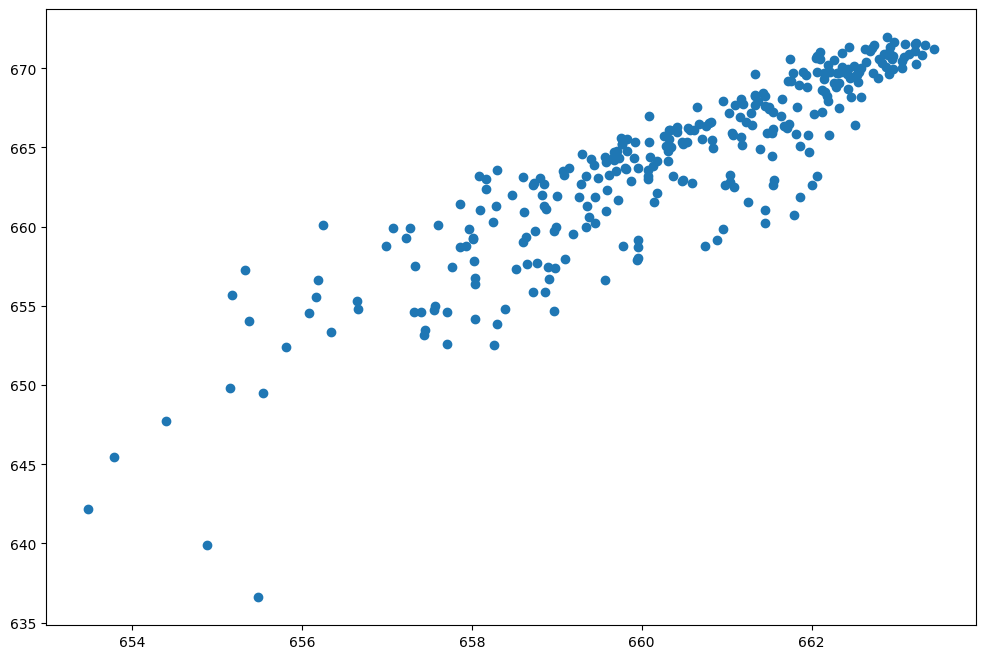

In [112]:
plt.figure(figsize=(12,8))
plt.scatter(fft_cor_data_binned, full_sim_data_binned)

In [92]:
reg = LinearRegression().fit(fft_cor_data_binned.reshape(-1, 1), full_sim_data_binned.reshape(-1, 1))

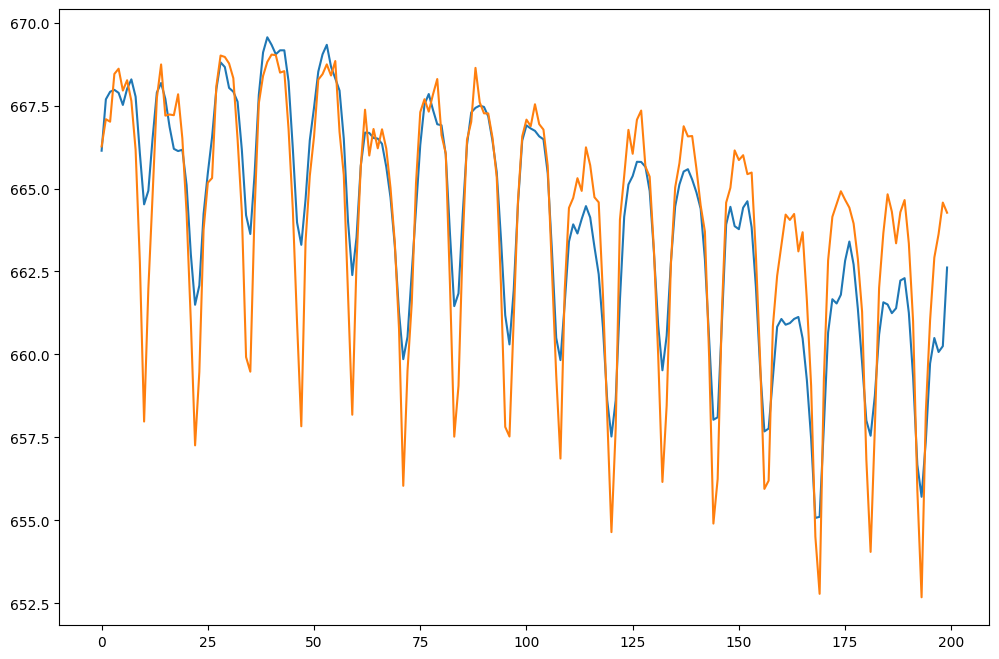

In [93]:
plt.figure(figsize=(12,8))
plt.plot(fft_cor_data_binned*reg.coef_[0] + reg.intercept_[0])
plt.plot(full_sim_data_binned)

In [113]:
def inv_quadratic(x, A, B, C):
    return A*np.sqrt(x+B) + C

opt_, cov_ = curve_fit(inv_quadratic, fft_cor_data_binned, full_sim_data_binned) 

/var/folders/w4/r1995s014fv25t05nkdm04g00000gn/T/ipykernel_43187/711302903.py:2: RuntimeWarning: invalid value encountered in sqrt
  return A*np.sqrt(x+B) + C


In [114]:
opt_

array([  16.29610479, -648.92492454,  609.16781058])

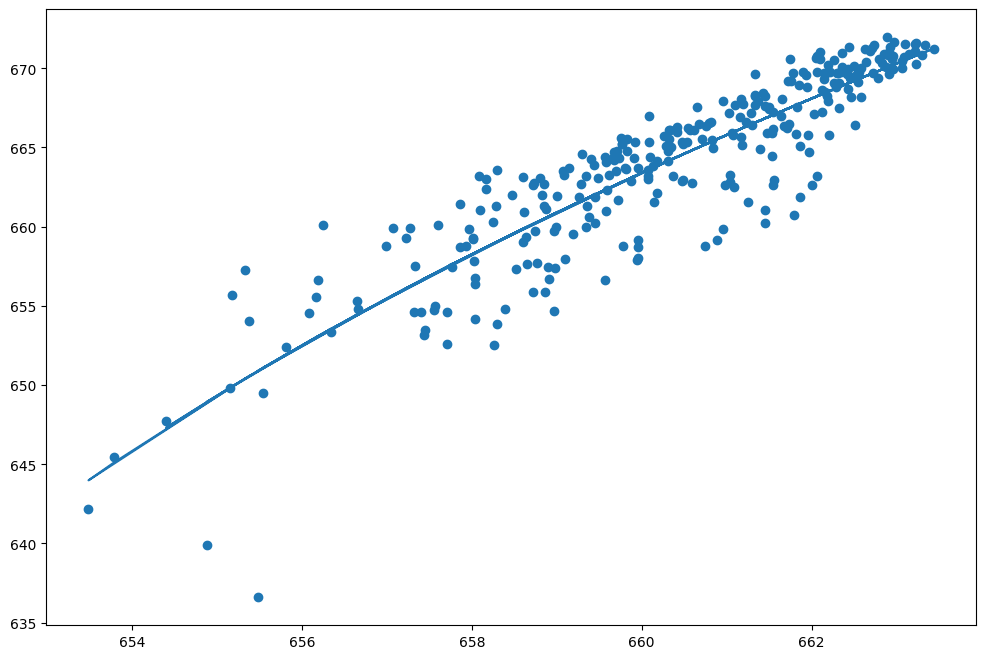

In [115]:
plt.figure(figsize=(12,8))
plt.scatter(fft_cor_data_binned, full_sim_data_binned)
plt.plot(fft_cor_data_binned, inv_quadratic(fft_cor_data_binned, *opt_))

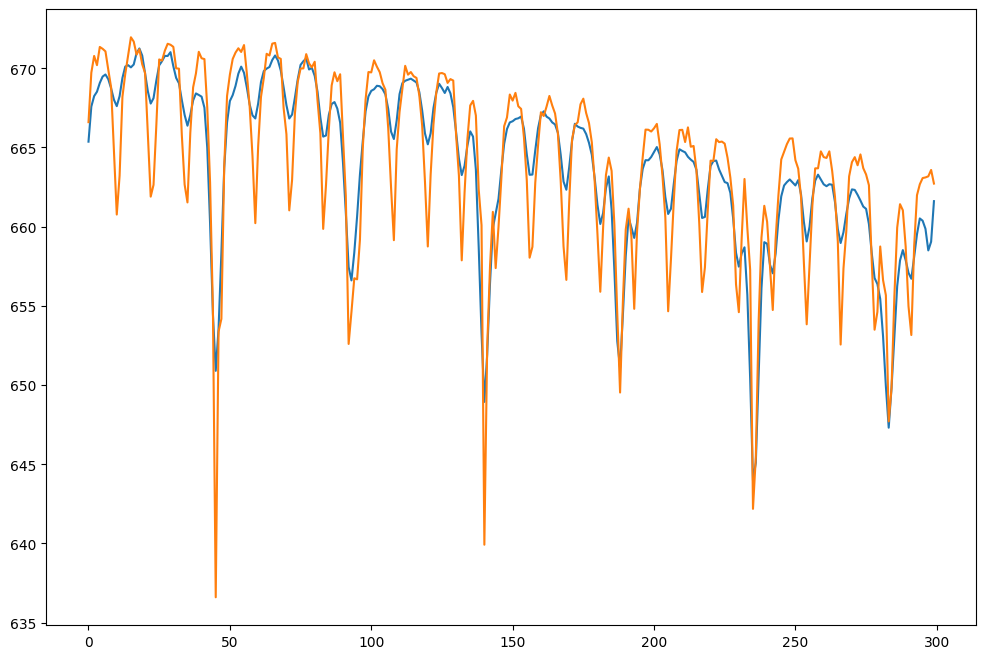

In [116]:
plt.figure(figsize=(12,8))
plt.plot(inv_quadratic(fft_cor_data_binned, *opt_))
plt.plot(full_sim_data_binned)